# CA5 Phase2

### The purpose of this project is to create a Neural Network with TensorFlow and Keras library and Train it with given dataset and then test it with given test dataset

# Imports

In [44]:
import os
import random
import tensorboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.utils import *
from sklearn.metrics import classification_report

# Body

# Part 1: Data Analysis and Preprocess¶

In [2]:
train_path = "../dataset/train"

In [3]:
img_path = []
labels = []
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    for img in os.listdir(folder_path):
        img_path.append(os.path.join(folder_path, img))
        labels.append(folder)

In [4]:
df = pd.DataFrame({
    "image" : img_path,
    "label" : labels
})

In [5]:
df.count()

image    1953
label    1953
dtype: int64

In [6]:
df['label'].value_counts().count()

4

In [7]:
df['label'].value_counts()

bald_eagle    523
racoon        509
elk           462
raven         459
Name: label, dtype: int64

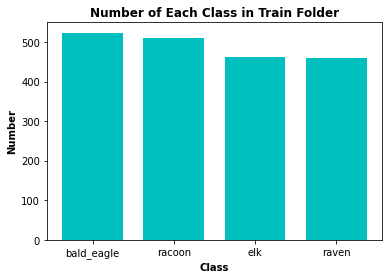

In [8]:
plt.bar(
    df['label'].value_counts().keys(),
    df['label'].value_counts().values,
    color='c',
    width=.75
)
plt.xlabel("Class", fontweight ='bold')
plt.ylabel("Number", fontweight ='bold')
plt.title("Number of Each Class in Train Folder", fontweight ='bold')
plt.show()

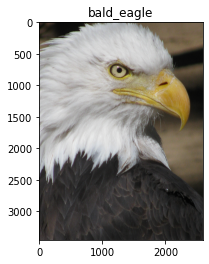

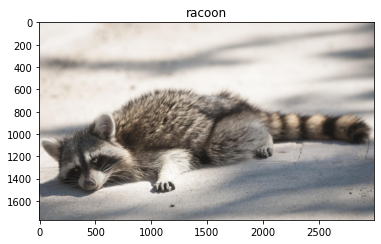

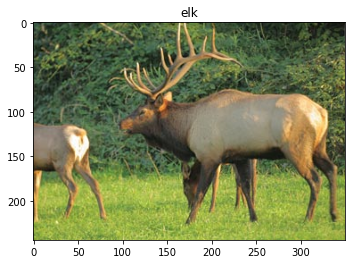

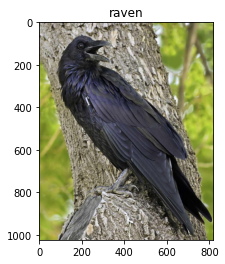

In [9]:
for name in df['label'].value_counts().keys():
    rand_num = random.randint(0, len(df))
    while df['label'][rand_num] != name:
        rand_num = random.randint(0, len(df))
    img = load_img(df['image'][rand_num])
    title = df['label'][rand_num]
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [10]:
classes_labels = {
    df['label'].value_counts().keys()[i] : i for i in range(0, df['label'].value_counts().count())
}

In [11]:
classes_labels

{'bald_eagle': 0, 'racoon': 1, 'elk': 2, 'raven': 3}

In [12]:
df['label']

0       bald_eagle
1       bald_eagle
2       bald_eagle
3       bald_eagle
4       bald_eagle
           ...    
1948        racoon
1949        racoon
1950        racoon
1951        racoon
1952        racoon
Name: label, Length: 1953, dtype: object

In [13]:
for i in range(len(df)):
    df['label'][i] = classes_labels[df['label'][i]]

In [14]:
df['label']

0       0
1       0
2       0
3       0
4       0
       ..
1948    1
1949    1
1950    1
1951    1
1952    1
Name: label, Length: 1953, dtype: object

In [15]:
one_hot = [str(to_categorical(i, df['label'].value_counts().count())) for i in df['label']]

In [16]:
df['label'] = one_hot

In [17]:
df['label']

0       [1. 0. 0. 0.]
1       [1. 0. 0. 0.]
2       [1. 0. 0. 0.]
3       [1. 0. 0. 0.]
4       [1. 0. 0. 0.]
            ...      
1948    [0. 1. 0. 0.]
1949    [0. 1. 0. 0.]
1950    [0. 1. 0. 0.]
1951    [0. 1. 0. 0.]
1952    [0. 1. 0. 0.]
Name: label, Length: 1953, dtype: object

### As seen above, labels are one hot encoded

### We dont have an order or rank in our classes, but, when label encoding is performed, the class names are ranked. Due to this, there is a very high probability that the model captures the relationship between classes based on their ranks. So, we use One Hot Encoding to solve this problem.

In [18]:
dataGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1 / 255.0,
    validation_split = 0.25,
)

### Shuffle dataframe befor dividing to Train and Validation:

In [19]:
df = df.sample(frac = 1)

In [20]:
df

image          label
1295        ../dataset/train/elk/a73e517a698bdb95c1.jpg  [0. 0. 1. 0.]
347   ../dataset/train/bald_eagle/92df87cf11bb26b03f...  [1. 0. 0. 0.]
1089        ../dataset/train/elk/be32646b34366ee010.jpg  [0. 0. 1. 0.]
200   ../dataset/train/bald_eagle/6df7890c969b4193ad...  [1. 0. 0. 0.]
445   ../dataset/train/bald_eagle/d82f49e046a901824f...  [1. 0. 0. 0.]
...                                                 ...            ...
1661     ../dataset/train/racoon/f5e36fa8c8eb2eb668.jpg  [0. 1. 0. 0.]
943       ../dataset/train/raven/c564b8271a4b073660.jpg  [0. 0. 0. 1.]
1090        ../dataset/train/elk/aad827d441c5e4644e.jpg  [0. 0. 1. 0.]
1543     ../dataset/train/racoon/58666802bad997537c.jpg  [0. 1. 0. 0.]
782       ../dataset/train/raven/9b5647442c6609aadc.jpg  [0. 0. 0. 1.]

[1953 rows x 2 columns]

In [21]:
TrainData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'label',
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = False,
    validate_filenames = False
)   

Found 1465 non-validated image filenames belonging to 4 classes.


In [22]:
ValidationData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'label',
    target_size = (128, 128),
    color_mode = 'grayscale',
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False,
    validate_filenames = False
)

Found 488 non-validated image filenames belonging to 4 classes.


# Part 2: Make Neural Network

In [45]:
inpt = layers.Input(shape=(128, 128, 1))

output = layers.Flatten()(inpt)
output = layers.Dense(1024, activation = "relu")(output)
output = layers.Dense(512, activation = "relu")(output)
output = layers.Dense(256, activation = "relu")(output)
output = layers.Dense(4, activation = "softmax")(output)

In [24]:
model = models.Model(inputs = inpt, outputs = output)

In [25]:
model.compile(optimizer = optimizers.SGD(learning_rate = 0.01), loss = "categorical_crossentropy", metrics = ["accuracy"]) 

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1024)              16778240  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 17,435,396
Trainable params: 17,435,396
Non-tra

### The number of parameters is equal to the product of the number of nodes in two consecutive layers.

# Part 3: Data Classification

In [27]:
history = model.fit(TrainData, validation_data = ValidationData, epochs=20)

Epoch 1/20
 7/46 [===>..........................] - ETA: 9s - loss: 1.5093 - accuracy: 0.2545 

/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


46/46 [==============================] - 19s 397ms/step - loss: 1.3611 - accuracy: 0.3386 - val_loss: 1.3546 - val_accuracy: 0.3545
Epoch 2/20
46/46 [==============================] - 17s 368ms/step - loss: 1.2382 - accuracy: 0.4362 - val_loss: 1.1584 - val_accuracy: 0.4918
Epoch 3/20
46/46 [==============================] - 17s 373ms/step - loss: 1.1947 - accuracy: 0.4560 - val_loss: 1.1745 - val_accuracy: 0.4344
Epoch 4/20
46/46 [==============================] - 17s 372ms/step - loss: 1.1506 - accuracy: 0.4942 - val_loss: 1.0930 - val_accuracy: 0.5553
Epoch 5/20
46/46 [==============================] - 17s 366ms/step - loss: 1.0989 - accuracy: 0.5270 - val_loss: 1.0643 - val_accuracy: 0.5266
Epoch 6/20
46/46 [==============================] - 17s 366ms/step - loss: 1.0781 - accuracy: 0.5263 - val_loss: 0.9949 - val_accuracy: 0.6045
Epoch 7/20
46/46 [==============================] - 17s 366ms/step - loss: 1.0481 - accuracy: 0.5638 - val_loss: 0.9937 - val_accuracy: 0.5984
Epoch 8/20

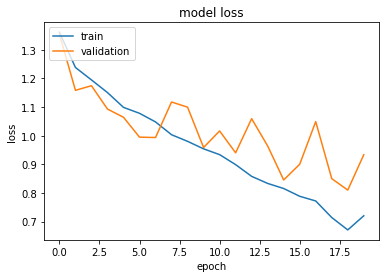

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

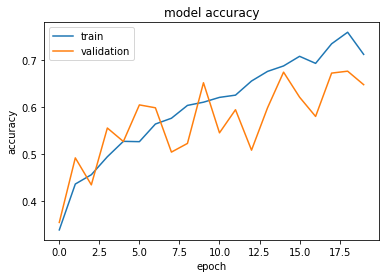

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
y_pred = model.predict(TrainData, verbose = 1)
y_pred_bool = np.argmax(y_pred, axis = 1)

#print(classification_report(y_test, y_pred_bool))

46/46 [==============================] - 12s 258ms/step


In [31]:
len(y_pred_bool)

1465

In [43]:
y_pred

array([[0.00342736, 0.03172985, 0.30336437, 0.66147846],
       [0.03929094, 0.42384547, 0.23049027, 0.30637327],
       [0.14631364, 0.08215314, 0.11239733, 0.65913594],
       ...,
       [0.02807458, 0.42568395, 0.14689763, 0.39934382],
       [0.01031841, 0.08727346, 0.8436461 , 0.05876196],
       [0.47746634, 0.04834875, 0.11120159, 0.36298338]], dtype=float32)

In [46]:
y_pred_bool

array([3, 1, 3, ..., 1, 2, 0])

In [32]:
for y in y_pred_bool:
    print(y)

3
1
3
2
0
3
1
2
2
1
3
3
2
0
0
3
3
3
2
3
3
1
1
2
3
3
2
3
1
0
1
3
3
3
1
3
0
1
2
3
1
0
3
2
0
1
1
2
3
2
1
1
2
3
1
3
3
3
0
3
3
1
1
3
1
1
3
0
2
2
2
1
2
2
2
3
3
3
3
3
3
2
2
3
3
3
3
1
3
2
3
3
3
2
3
3
3
2
3
1
2
3
1
0
1
1
0
1
3
2
2
3
3
3
3
3
3
2
1
1
3
0
2
1
0
3
3
2
3
2
3
3
2
2
1
3
2
1
2
1
3
3
2
2
0
3
3
3
0
3
2
3
2
3
2
2
1
2
1
1
3
3
3
1
2
1
2
3
1
2
2
1
3
3
2
1
2
2
1
3
1
2
2
2
0
1
2
1
3
2
3
3
3
3
1
1
3
0
2
3
3
3
2
2
3
1
3
2
2
1
3
0
1
2
3
3
0
3
0
3
1
1
1
2
2
2
3
1
2
2
0
3
1
3
3
1
3
2
3
0
2
2
3
3
2
2
3
2
2
2
2
1
2
3
2
2
2
3
3
0
1
3
3
3
3
1
2
3
3
2
1
1
2
3
2
1
3
2
1
3
2
3
1
1
1
1
3
2
3
2
1
1
1
2
3
2
2
0
3
1
1
3
2
3
3
3
3
3
0
3
3
3
3
3
3
2
3
2
3
0
1
2
3
3
3
2
3
2
3
2
3
3
3
3
3
2
0
3
3
3
1
3
3
3
3
3
3
3
3
3
1
2
3
3
1
2
2
2
3
2
0
3
3
2
3
3
3
3
2
3
1
3
3
3
1
3
2
2
3
1
1
3
3
2
3
1
3
3
3
2
3
2
3
2
3
0
3
1
1
2
1
1
1
3
3
0
2
2
3
0
1
2
1
2
2
3
1
3
2
3
2
2
1
2
0
2
2
3
3
3
2
1
3
2
3
2
3
3
3
3
2
3
3
3
1
3
0
1
0
0
3
3
3
3
1
1
2
3
3
3
3
3
0
3
2
1
1
2
3
2
3
2
0
3
2
2
2
3
3
3
1
3
2
2
3
3
1
2
3
2
3
3
0
2
3
3
0
3
2
0


In [50]:
y_pred_one_hot = [str(to_categorical(i, 4)) for i in y_pred_bool]

In [51]:
y_pred_one_hot

['[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 1. 0.]',
 '[1. 0. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 1. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 1. 0.]',
 '[1. 0. 0. 0.]',
 '[1. 0. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[1. 0. 0. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[1. 0. 0. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[1. 0. 0. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 1. 0.]',
 '[1. 0. 0. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 0. 1. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 1. 0.]',
 '[0. 0. 0. 1.]',
 '[0. 1. 0. 0.]',
 '[0. 0. 0

In [53]:
print(classification_report(df['label'][0:len(y_pred_bool)], y_pred_one_hot))

               precision    recall  f1-score   support

[0. 0. 0. 1.]       0.24      0.43      0.31       344
[0. 0. 1. 0.]       0.27      0.37      0.31       353
[0. 1. 0. 0.]       0.25      0.17      0.20       368
[1. 0. 0. 0.]       0.30      0.09      0.14       400

     accuracy                           0.26      1465
    macro avg       0.27      0.26      0.24      1465
 weighted avg       0.27      0.26      0.24      1465

